# Sprint9課題 アンサンブル学習、グループワーク

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# StanardScalerクラスをインポート
from sklearn.preprocessing import StandardScaler

#学習モデルをインポート
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

#評価用のライブラリ
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [4]:
#read data
df = pd.read_csv('/Users/ohmori/diveintocode-ml/week4/train.csv')
df.loc[:, ["GrLivArea", "YearBuilt"]].head()

,GrLivArea,YearBuilt
0,1710,2003
1,1262,1976
2,1786,2001
3,1717,1915
4,2198,2000


In [5]:
#欠損確認
#欠損なし
df.loc[:, ["GrLivArea", "YearBuilt"]].isnull().sum()

GrLivArea    0
YearBuilt    0
dtype: int64

In [11]:
#train_test_split
from sklearn.model_selection import train_test_split

def train_test(X, y, train_size = 8/10):
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=train_size, test_size=(1- train_size))
        return X_train, X_valid, y_train, y_valid

In [12]:
def scale(X_train, X_valid, y_train, y_valid):
        #np arrayに変換
        X_train = np.array(X_train)
        X_valid = np.array(X_valid)
        y_train = np.array(y_train)
        y_valid = np.array(y_valid)

        #shapeを(n_samples, 1)に
        y_train = y_train.reshape(-1, 1)
        y_valid = y_valid.reshape(-1, 1)

        #scale values
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)

        scaler.fit(y_train)
        y_train = scaler.transform(y_train)
        y_valid = scaler.transform(y_valid)
        
        return X_train, X_valid, y_train, y_valid

## 【問題1】ブレンディング
ブレンディングを実装し、単一モデルより精度があがる例を最低3つ示してください。精度があがるとは、検証用データに対する平均二乗誤差（MSE）が小さくなることを示します。

ブレンディングとは、N個の多様なモデルを独立して学習させ、推定結果を重み付けした上で足し合わせる方法です。最も単純には平均をとります。多様なモデルとは、以下のような条件を変化させることで作り出すものです。

手法（例：線形回帰、SVM、決定木、ニューラルネットワークなど）
ハイパーパラメータ（例：SVMのカーネルの種類、重みの初期値など）
入力データの前処理の仕方（例：標準化、対数変換、PCAなど）
重要なのはそれぞれのモデルが大きく異なることです。必ずしも単一モデルの精度が高い必要はありません。

回帰問題でのブレンディングは非常に単純であるため、scikit-learnには用意されていません。

補足

分類問題の場合は、多数決を行います。回帰問題に比べると複雑なため、scikit-learnにはVotingClassifierが用意されています。

[sklearn.ensemble.VotingClassifier — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

考察

どういった組み合わせが良いか、どのようにすると多様なモデルが作れるかを考えてみましょう。

In [15]:
import warnings
warnings.filterwarnings('ignore')

#fit, predictのための関数を用意
def fit_predict(model, X_train, X_valid, y_train):
        #np arrayに変換
        X_train = np.array(X_train)
        X_valid = np.array(X_valid)
        y_train = np.array(y_train)

        
        #shapeを(n_samples, 1)に
        y_train = y_train.reshape(-1, 1)
        
        #fit
        model.fit(X_train, y_train)
        
        #predict
        y_pred = model.predict(X_valid).reshape(-1, 1)
        
        return y_pred

#evaluate
def evaluate(y_valid, y_pred):
        #pd -> np array & reshape
        y_valid = np.array(y_valid).reshape(-1, 1)
        y_pred = np.array(y_pred).reshape(-1, 1)

        #MSE算出
        mse = (np.dot((y_valid - y_pred).T, (y_valid - y_pred))/len(y_valid))[0]
        return mse

In [16]:
lnr = LinearRegression()
svr = SVR()
dtr = DecisionTreeRegressor()

In [9]:
#test_train_split
X_train, X_valid, y_train, y_valid = train_test(df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size=4/5)
#scale data
X_train, X_valid, y_train, y_valid = scale(X_train, X_valid, y_train, y_valid)

In [10]:
#Linear Regression
y_pred_lnr = fit_predict(lnr, X_train, X_valid, y_train)
evaluate(y_valid, y_pred_lnr)

array([0.35837836])

In [11]:
#SVR
y_pred_svr = fit_predict(svr, X_train, X_valid, y_train)
evaluate(y_valid, y_pred_svr)

array([0.22259941])

In [12]:
#Decision Tree
y_pred_dtr = fit_predict(dtr, X_train, X_valid, y_train)
evaluate(y_valid, y_pred_dtr)

array([0.38744791])

重み付き平均を試してみる

In [13]:
#重み付き平均
#Linear : SVM : DT = 1: 3 : 6
evaluate(y_valid, ( (10/100) * y_pred_lnr + (30/100) * y_pred_svr + (60/100) * y_pred_dtr))

array([0.26208358])

In [14]:
#重み付き平均
#Linear : SVM : DT = 2: 2 : 6
evaluate(y_valid, ( (20/100) * y_pred_lnr + (20/100) * y_pred_svr + (60/100) * y_pred_dtr))

array([0.26336019])

In [15]:
#重み付き平均
#Linear : SVM : DT = 6: 2 : 2
evaluate(y_valid, ( (60/100) * y_pred_lnr + (20/100) * y_pred_svr + (20/100) * y_pred_dtr))

array([0.25926057])

In [16]:
#ブレンドの比率を変えてみる
ary = np.empty((0, 4))
for i in range(10+1):
        for j in range(0, 10 - i + 1):
                k = 10 - (i + j)
                mse = evaluate(y_valid, (i * y_pred_lnr + j * y_pred_svr + k * y_pred_dtr)/(i+j+k))[0]
                ary = np.append(ary, [np.array([i, j, k, mse])], axis=0)
ary

array([[ 0.        ,  0.        , 10.        ,  0.38744791],
       [ 0.        ,  1.        ,  9.        ,  0.34929951],
       [ 0.        ,  2.        ,  8.        ,  0.31596524],
       [ 0.        ,  3.        ,  7.        ,  0.28744508],
       [ 0.        ,  4.        ,  6.        ,  0.26373905],
       [ 0.        ,  5.        ,  5.        ,  0.24484714],
       [ 0.        ,  6.        ,  4.        ,  0.23076935],
       [ 0.        ,  7.        ,  3.        ,  0.22150569],
       [ 0.        ,  8.        ,  2.        ,  0.21705614],
       [ 0.        ,  9.        ,  1.        ,  0.21742072],
       [ 0.        , 10.        ,  0.        ,  0.22259941],
       [ 1.        ,  0.        ,  9.        ,  0.34662452],
       [ 1.        ,  1.        ,  8.        ,  0.31363009],
       [ 1.        ,  2.        ,  7.        ,  0.28544978],
       [ 1.        ,  3.        ,  6.        ,  0.26208358],
       [ 1.        ,  4.        ,  5.        ,  0.24353152],
       [ 1.        ,  5.

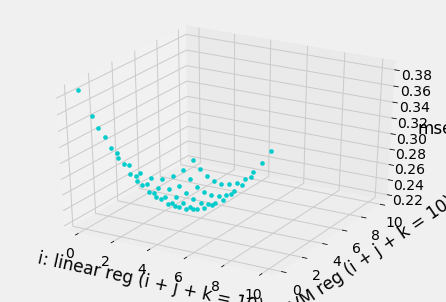

In [38]:
#可視化
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("i: linear reg (i + j + k = 10)")
ax.set_ylabel("j: SVM reg (i + j + k = 10)")
ax.set_zlabel("mse")

ax.plot(ary[:, 0], ary[:,1], ary[:, 3], "o", color="#00cccc", ms=4, mew=0.5)

blendingによって単体のモデルよりMSEが小さくなる組み合わせがあることがわかった。

## 【問題2】バギング
バギングを実装し、単一モデルより精度があがる例を最低1つ示してください。

バギングは入力データの選び方を多様化する方法です。学習データから重複を許した上でランダムに抜き出すことで、N種類のサブセット（ブートストラップサンプル）を作り出します。それらによってモデルをN個学習し、推定結果の平均をとります。ブレンディングと異なり、それぞれの重み付けを変えることはありません。

[sklearn.model_selection.train_test_split — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

scikit-learnのtrain_test_splitを、shuffleパラメータをTrueにして使うことで、ランダムにデータを分割することができます。これによりブートストラップサンプルが手に入ります。

推定結果の平均をとる部分はブースティングと同様の実装になります。

In [ ]:
#重複ありのサンプリングの確認
rand_idx = np.random.randint(0, n_samples, size=n_samples)
print(rand_idx)
value, count = np.unique(rand_idx, return_counts=True)
dict(zip(value, count))

In [ ]:
#比較として重複なしのサンプリングの確認
rand_idx_2= np.arange(0, n_samples)
print(rand_idx_2)
np.random.shuffle(rand_idx_2)
print(rand_idx_2)

value_2, count_2 = np.unique(rand_idx_2, return_counts=True)
dict(zip(value_2, count_2))

重複なしサンプリングができることを確認したのでBaggingを実装

[0.45418165]
[0.25077766]


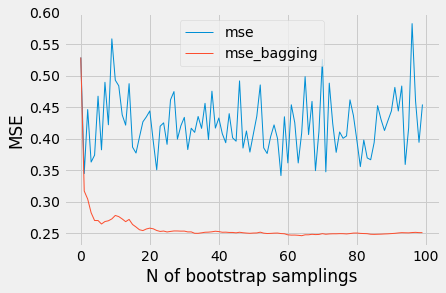

In [45]:
#train size = 80%
train_size = 80/100

#train_test_split
X_train, X_valid, y_train, y_valid = train_test(df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size)
#scale
X_train, X_valid, y_train, y_valid = scale(X_train, X_valid, y_train, y_valid)

#predict結果とmseを保管する箱を初期化
y_pred_rpt = np.empty((y_valid.shape[0], 0))
mse_ary = np.empty((1, 0))
mse_bag_ary = np.empty((1, 0))

for i in range(100):
        #重複ありのインデックスを生成 (0 to len(X))
        rand_idx = np.random.randint(0, X_train.shape[0], size=X_train.shape[0])
        
        #予測モデルのインスタンス生成
        dtr = DecisionTreeRegressor()
        
        #生成したインデックスを用いてXから重複を許してサンプリング
        #fit, predict
        y_pred = fit_predict(dtr, X_train[rand_idx, :], X_valid, y_train[rand_idx])
        
        #predict結果を保管
        y_pred_rpt = np.append(y_pred_rpt, np.array(y_pred), axis=1)
        #保管されたpredict結果の平均をとってbagging resultとする
        y_pred_bagging = y_pred_rpt.mean(axis=1)
        
        #mse計算
        mse = evaluate(y_valid, y_pred)
        mse_bag = evaluate(y_valid, y_pred_bagging)
        
        #mse保管
        mse_ary = np.append(mse_ary, mse)
        mse_bag_ary = np.append(mse_bag_ary, mse_bag)

#結果をplot
plt.plot(mse_ary, label='mse', linewidth=1)
plt.plot(mse_bag_ary, label='mse_bagging', linewidth=1)
plt.xlabel('N of bootstrap samplings')
plt.ylabel('MSE')
plt.legend()

baggingした予測値でloop毎にmseの低下を確認できた。0.25程度に収束した

## 【問題3】スタッキング
スタッキングを実装し、単一モデルより精度があがる例を最低1つ示してください。

スタッキングの手順は以下の通りです。最低限ステージ0とステージ1があればスタッキングは成立するため、それを実装してください。まずは
$K_0=3,M_0=2$程度にします。<br>


<br>学習時<br>
<br>ステージ 0<br>

学習データを$K_0$個に分割する。分割した内の ($K_0−1$)個をまとめて学習用データ、残1
個を推定用データとする組み合わせが $K_0$個作れる。<br>
あるモデルのインスタンスを$K_0$個用意し、異なる学習用データを使い学習する。<br>
それぞれの学習済みモデルに対して、使っていない残り1個の推定用データを入力し、推定値を得る（これをブレンドデータと呼ぶ）。<br>
さらに、異なるモデルのインスタンスも $K_0$個用意し、同様のことを行う。モデルが$M_0$個あれば、$M_0$個のブレンドデータが得られる。<br>

<br>ステージ$i$<br>

ステージ $i−1$のブレンドデータを$M_{i−1}$次元の特徴量を持つ学習用データと考え、 $K_i$個に分割する。以下同様である。<br>

<br>ステージ$N$＊最後のステージ<br>

ステージ $N−1$の $M_{N−1}$個のブレンドデータを $M_{N−1}$次元の特徴量の入力として、1種類のモデルの学習を行う。これが最終的な推定を行うモデルとなる。<br>

<br>推定時<br>
<br>ステージ 0<br>

テストデータを $K_{0}\times M_{0}$個の学習済みモデルに入力し、$K_{0}\times M_{0}$個の推定値を得る。これを $K_{0}$の軸で平均値を求め$M_{0}$ 次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）<br>

<br>ステージ$i$<br>

ステージ $i-1$で得たブレンドテストを$K_{i}\times M_{i}$個の学習済みモデルに入力し、$K_{i}\times M_{i}$個の推定値を得る。これを $K_{i}$ の軸で平均値を求め$M_{i}$次元の特徴量を持つデータを得る。（ブレンドテストと呼ぶ）<br>

<br>ステージ $N$ ＊最後のステージ<br>

ステージ$N-1$で得たブレンドテストを学習済みモデルに入力し、推定値を得る。<br>

In [29]:
#数字をTrue, Falseのindexで取得する関数
def convert_index_to_bool_array(idx, size):
        bl =  np.zeros(size, dtype=bool)
        bl[idx] = True  
        return bl

In [30]:
#bool反転の関数
def get_reverse_bool(bool_to_reverse):
        return ((-1) * bool_to_reverse + 1).astype(bool) 

In [31]:
def generate_model_instance(model_name):
        if (model_name == 'linear_regression'):
                return LinearRegression()
        
        elif (model_name == 'decision_tree'):
                return DecisionTreeRegressor()

stage 0と1だけで実装

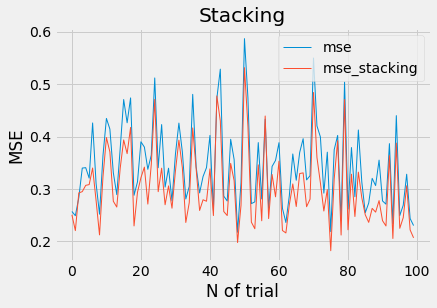

In [46]:
#mseを格納する箱を初期化
mse_rpt = np.empty((1, 0))
mse_stack_rpt = np.empty((1, 0))

#train size 80%
train_size = 80/100

#分割数K, モデル数M
K_0 = 3
M_0 = 2
#使うモデルのリスト
model_0 = ['linear_regression', 'decision_tree']

#100回試行して安定的にパフォーマンス出るか確認
for _ in range(100):
        #train_test_split
        X_train, X_test, y_train, y_test= train_test(df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size)
        #scale
        X_train, X_test, y_train, y_test= scale(X_train, X_test, y_train, y_test)
        
        #trainとtestのサンプル数を保管
        n_train_samples = X_train.shape[0]
        n_test_samples = X_test.shape[0]
        
    #学習時
        #stage 0
        #Trainとvalidationデータのインデックス格納のための配列を初期化
        idx_train = np.empty((n_train_samples, 0))
        idx_valid = np.empty((n_train_samples, 0))
        
        #分割数分のインデックスを生成
        for i in range(K_0):
                #validationデータのインデックスを生成（数字）
                idx = np.arange(round(n_train_samples * (i / K_0)), round(n_train_samples * ((i + 1) / K_0)))
                #数字の羅列を、対応するインデックスがTrueになった配列に変換
                idx = convert_index_to_bool_array(idx, n_train_samples).reshape(-1, 1)
                #ndarrayに格納
                idx_valid = np.append(idx_valid, idx, axis=1).astype(bool)#shape(n_train_samples, K_0)

        #validationの反転がtrainデータ
        idx_train = get_reverse_bool(idx_valid) #shape(n_train_samples, K_0)

        #モデルと予測値の格納先を初期化
        model_instance_stage_0 = [[] for j in range(K_0)] #shape(M_0, K_0)
        blend_data_stage_0 =  np.empty((n_train_samples, M_0))

        for i in range(M_0):
                for j in range(K_0):
                        #モデルのインスタンスを生成して格納
                        model_instance_stage_0[i].append(generate_model_instance(model_0[i]))                
                        #fit & predictして
                        pred = fit_predict(model_instance_stage_0[i][j], X_train[idx_train[:, j]], X_train[idx_valid[:, j]], y_train[idx_train[:, j]]).reshape(-1,)
                        #prediction dataをblendして新たなfeatureに(idx_validがTrueのところにpredを入れる)
                        blend_data_stage_0[idx_valid[:, j], i] =  pred

        #stage kは無し

        #stage N( N=1)
        #モデルインスタンス生成
        model_instance_stage_n = LinearRegression()
        #blend_dataを用いてfit
        blend_data_stage_n  = fit_predict(model_instance_stage_n, blend_data_stage_0, X_test, y_train).reshape(-1,)

    #推定時
        #stage 0
        #blend testの格納先を初期化
        blend_test_stage_0 =  np.empty((n_test_samples, M_0))
        for i in range(M_0):
                #予測値の格納先を初期化
                pred = np.empty((n_test_samples, 0))
                for j in range(K_0):
                        #stage0の学習済みモデルにvalid dataを入れてpredict
                        pred = np.append(pred, model_instance_stage_0[i][j].predict(X_test).reshape(-1, 1), axis=1)
                #分割数方向に平均をとって、shape(n_test_samples, model数)のブレンドテストを生成
                blend_test_stage_0[:, i] =  np.mean(pred, axis=1)

        #stage k

        #stage N( N=1)
        prediction = model_instance_stage_n.predict(blend_test_stage_0)

        #----------------------------------

        lnr = LinearRegression()
        y_pred = fit_predict(lnr, X_train, X_test, y_train).reshape(-1, 1)

        mse_rpt = np.append(mse_rpt, evaluate(y_test, y_pred))
        mse_stack_rpt = np.append(mse_stack_rpt, evaluate(y_test, prediction))


#plot
plt.style.use('fivethirtyeight')
plt.plot(mse_rpt, label='mse', linewidth = 1.0)
plt.plot(mse_stack_rpt, label='mse_stacking', linewidth = 1.0)
plt.title('Stacking')
plt.xlabel('N of trial')
plt.ylabel('MSE')
plt.legend()

plt.show()

大体の試行回においてstackingした場合の方がmseが低下していることを確認できた。stackingの効果を確かめられた。

### ステージ数とK, Mの数を一般化してクラス化

pyファイルは[こちら](https://github.com/ohmorimori/diveintocode-ml/blob/master/diveintocode-term1/ml-scratch/model/scratch_stacking.py)

In [8]:
import sys

string = "/Users/ohmori/diveintocode-ml/diveintocode-term1/ml-scratch/model"
if (string not in sys.path):
        sys.path.append(string)


In [9]:
#スクラッチで書いたstackingクラスをインポート
from scratch_stacking import ScratchStacking

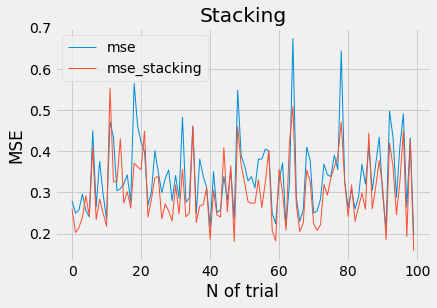

In [17]:
split_list = [3, 5, 4, 2, 1]#各ステージにおける分割数Kのリスト
model_list = [
        ['lnr', 'dtr'],
        ['lnr', 'dtr'],
        ['lnr'],
        ['lnr', 'dtr', 'svr'],
        ['lnr']
]#各ステージにおけるモデルのリスト

mse_rpt = np.empty((1, 0))
mse_stack_rpt = np.empty((1, 0))

#train size 80%
train_size = 80/100

#１００回試行してパフォーマンス確認
for _ in range(100):
        #train_test_split
        X_train, X_test, y_train, y_test= train_test(df.loc[:, ["GrLivArea", "YearBuilt"]], df["SalePrice"], train_size)
        #scale
        X_train, X_test, y_train, y_test= scale(X_train, X_test, y_train, y_test)
        #通常のfit & predict
        lnr = LinearRegression()
        y_pred = fit_predict(lnr, X_train, X_test, y_train).reshape(-1, 1)
        mse_rpt = np.append(mse_rpt, evaluate(y_test, y_pred))
        
        #stackingでfit & predict
        stack = ScratchStacking()
        stack.fit(split_list, model_list, X_train, y_train)
        stack_pred = stack.predict(X_test)
        stack_mse = stack.evaluate(y_test, stack_pred)

        mse_stack_rpt = np.append(mse_stack_rpt, stack_mse)
#plot
plt.style.use('fivethirtyeight')
plt.plot(mse_rpt, label='mse', linewidth = 1.0)
plt.plot(mse_stack_rpt, label='mse_stacking', linewidth = 1.0)
plt.title('Stacking')
plt.xlabel('N of trial')
plt.ylabel('MSE')
plt.legend()

plt.show()

任意のstage数に対してstackingを実現するクラスを実装できた。

## 【問題4】（アドバンス課題）Microsoft Malware Prediction
時間的に余裕がある場合は、KaggleのMalwareコンペを題材に、アンサンブル学習を実際に利用してみましょう。EDAからはじめ、推定値の提出まで挑戦してください。

[Microsoft Malware Prediction | Kaggle](https://www.kaggle.com/c/microsoft-malware-prediction)
です。